<h1> MOVIE RECOMENDATION </h1>

<h2> Import Libraries </h2> 

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

<h1> Exploratory Data Analysis (EDA) </h1>

<h2> Preprocessing</h2> 

In [3]:
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')
    
    row = list()
    files=['combined_data_1.txt','combined_data_2.txt','combined_data_3.txt','combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] 
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()

In [4]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',',names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [4]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<h3> Checking for NaN values </h3>

In [6]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


<h3> Removing Duplicates </h3>

In [7]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


 <h3> Basic Statistics (#Ratings, #Users, and #Movies)</h3>

In [8]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


<h2>Spliting data into Train and Test </h2>

In [5]:
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

<h3> Basic Statistics in Train data (#Ratings, #Users, and #Movies)</h3>

In [10]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 58725000
Total No of Users   : 322358
Total No of movies  : 16376


<h3>Basic Statistics in Test data (#Ratings, #Users, and #Movies)</h3>

In [11]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


 <h2> Exploratory Data Analysis on Train data </h2>

In [6]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<h3>Distribution of ratings </h3>

<IPython.core.display.Javascript object>


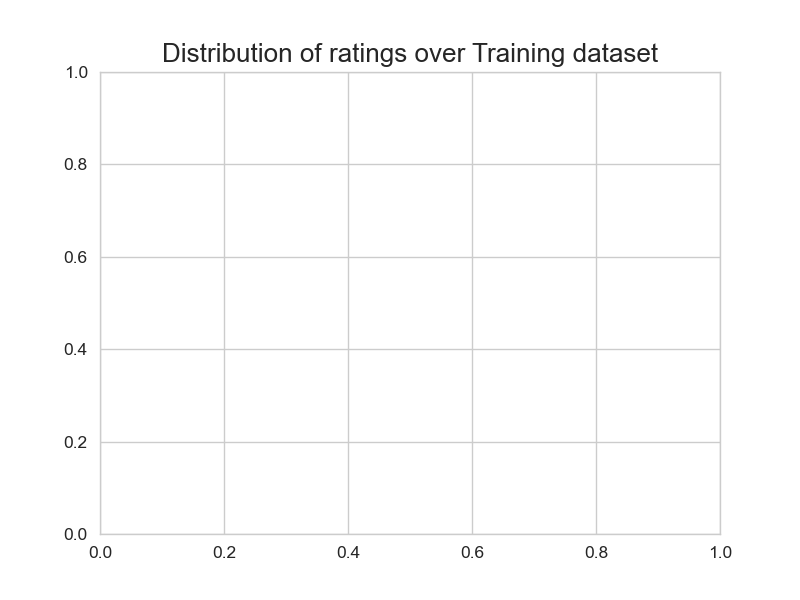

<IPython.core.display.Javascript object>


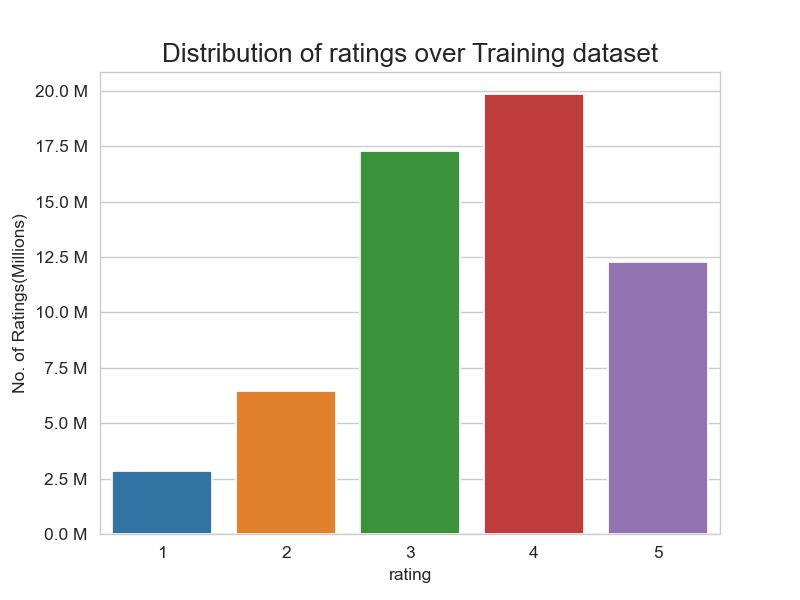

In [7]:
import warnings 
warnings.filterwarnings("ignore")
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

<p style="font-size:13px"> <b>Add new column (week day) to the data set  for analysis.</b></p>

In [14]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] =train_df.date.dt.day_name()

train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


In [15]:
train_df.tail()

,movie,user,rating,date,day_of_week
58724995,16872,541549,5,2005-03-18,Friday
58724996,15662,2108623,4,2005-03-18,Friday
58724997,12034,281496,5,2005-03-18,Friday
58724998,13529,1286400,5,2005-03-18,Friday
58724999,10121,1268483,4,2005-03-18,Friday


<h3> Number of Ratings per a month </h3>

<IPython.core.display.Javascript object>


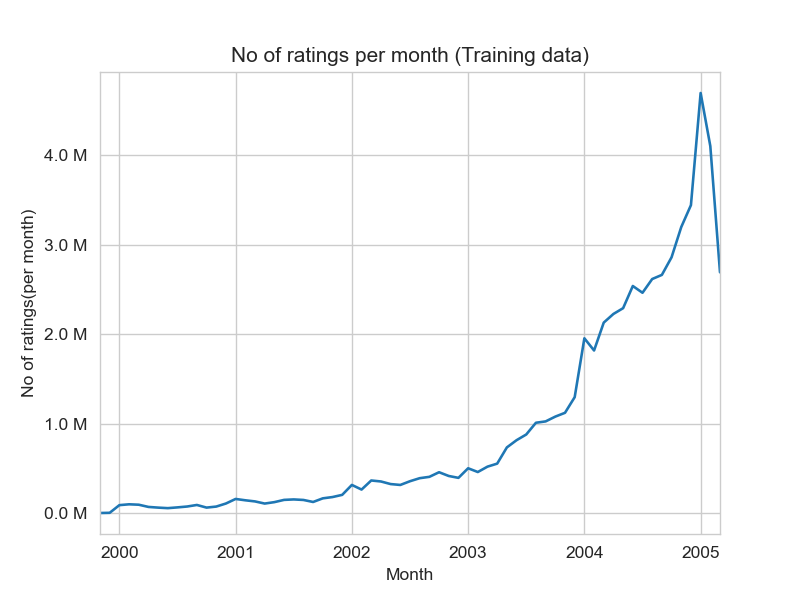

In [16]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<h3> Analysis on the Ratings given by user </h3>

In [17]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     15875
2439493    14712
387418     14112
1639792     9748
1932594     7358
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


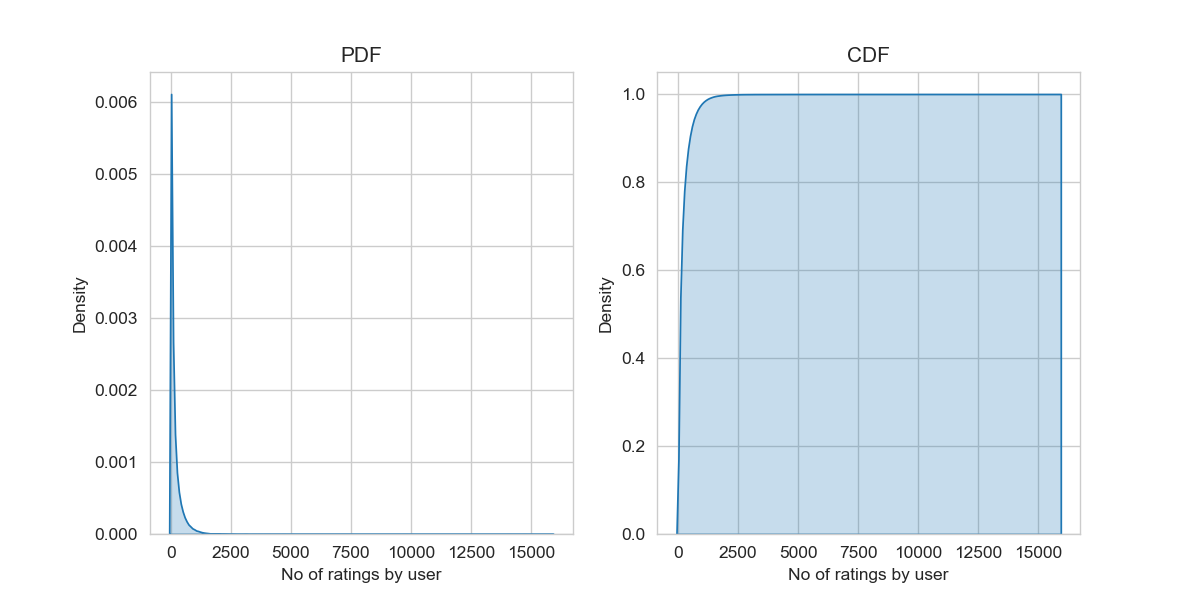

In [18]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [19]:
no_of_rated_movies_per_user.describe()

count    322358.000000
mean        182.173236
std         275.426123
min           1.000000
25%          25.000000
50%          81.000000
75%         224.000000
max       15875.000000
Name: rating, dtype: float64

In [20]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


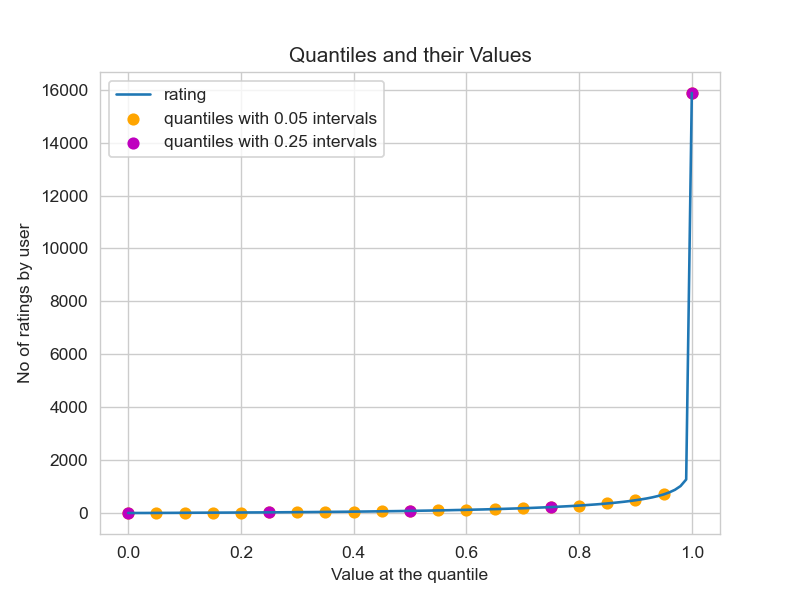

In [21]:
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [22]:
quantiles[::5]

0.00        1
0.05        4
0.10        9
0.15       14
0.20       19
0.25       25
0.30       33
0.35       42
0.40       53
0.45       65
0.50       81
0.55       99
0.60      121
0.65      148
0.70      181
0.75      224
0.80      282
0.85      362
0.90      483
0.95      703
1.00    15875
Name: rating, dtype: int64

__how many ratings at the last 5% of all ratings__??

In [23]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 14120



<h3> Analysis of ratings of a movie given by a user </h3>

<IPython.core.display.Javascript object>


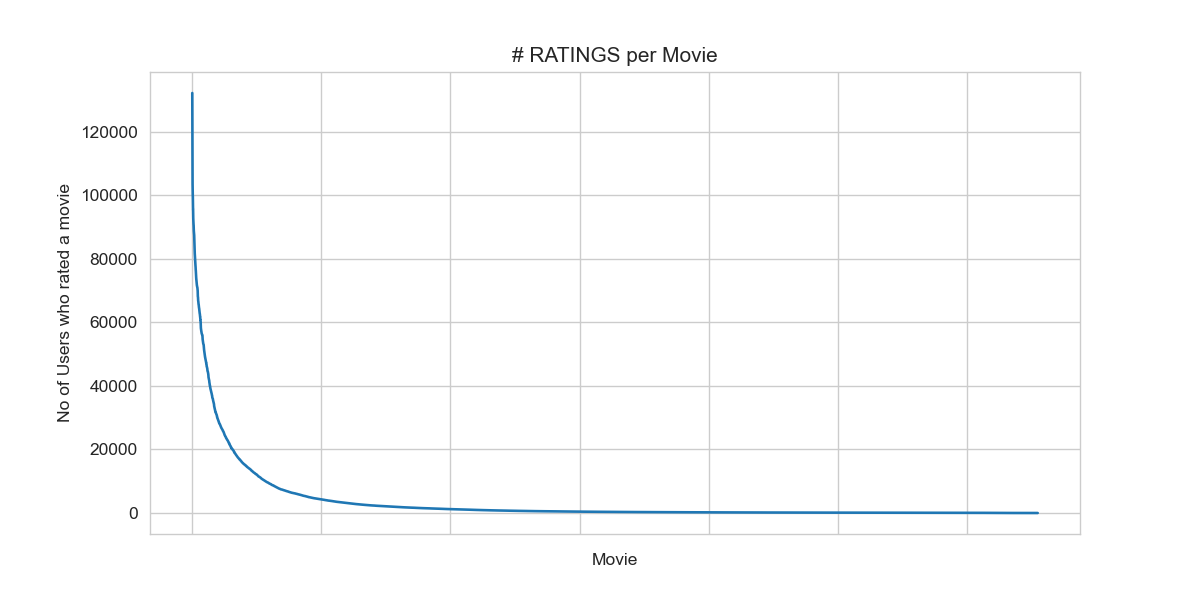

In [24]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

<h3>Number of ratings on each day of the week</h3>

<IPython.core.display.Javascript object>


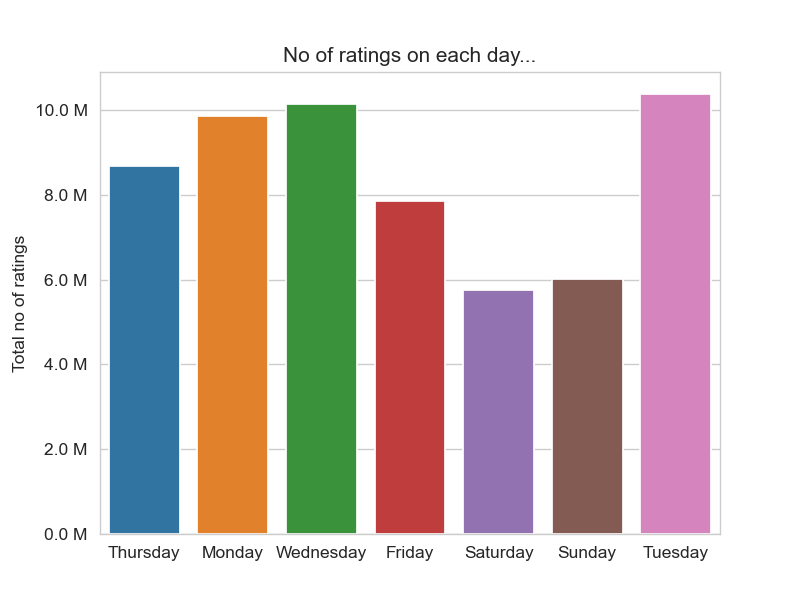

In [25]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


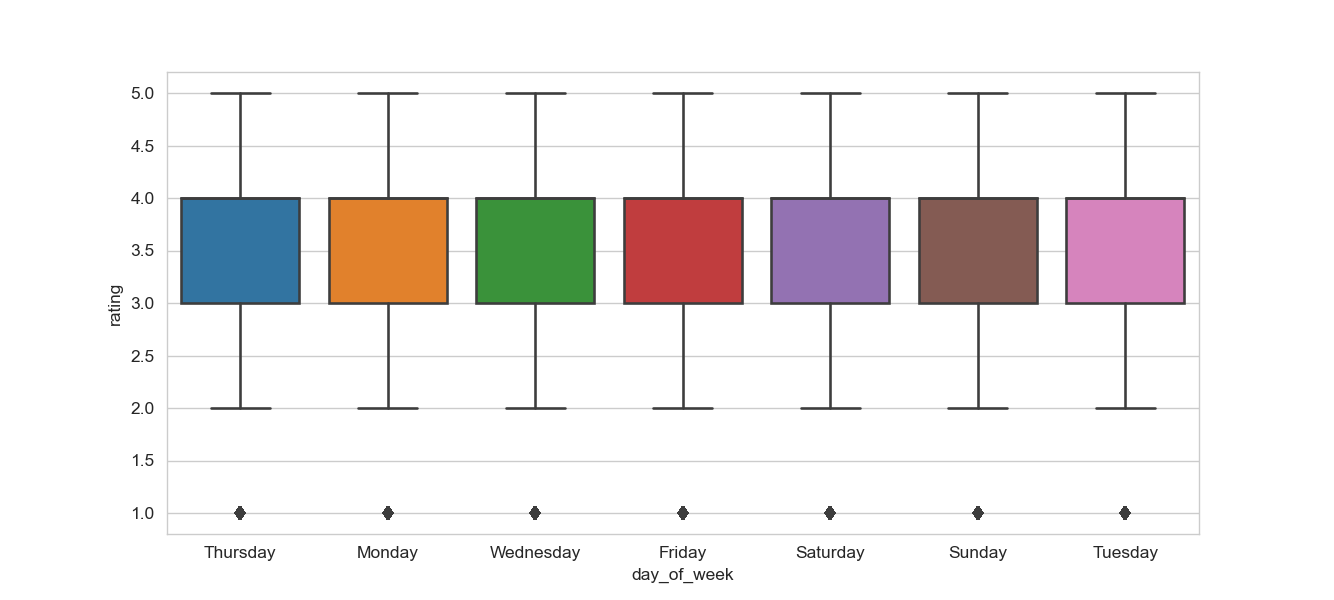

0:00:58.649301


In [26]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

In [27]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.549630
Monday       3.543068
Saturday     3.554626
Sunday       3.558512
Thursday     3.549509
Tuesday      3.538902
Wednesday    3.552598
Name: rating, dtype: float64




<h3> Creating sparse matrix from data frame </h3>

In [8]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:06.678054


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [9]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.87527350764893 % 


<h4>Creating sparse matrix from test data frame </h4>

In [10]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:02.391468


<p><b>The Sparsity of Test data Matrix</b></p>

In [11]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


<h3>Finding Global average of all movie ratings, Average rating per user, and Average rating per movie</h3>

In [42]:
def get_average_ratings(sparse_matrix, of_users):
    
    ax = 1 if of_users else 0 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1

    is_rated = sparse_matrix!=0
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    u,m = sparse_matrix.shape

    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    return average_ratings

<h4> finding global average of all movie ratings </h4>

In [33]:
train_averages = dict()
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.548525176670924}

<h4>finding average rating per user</h4>

In [34]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3846153846153846


<h4> finding average rating per movie</h4>

In [35]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 9 :',train_averages['movie'][1])


 AVerage rating of movie 9 : 3.625984251968504


<h4>PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)</h4>

<IPython.core.display.Javascript object>


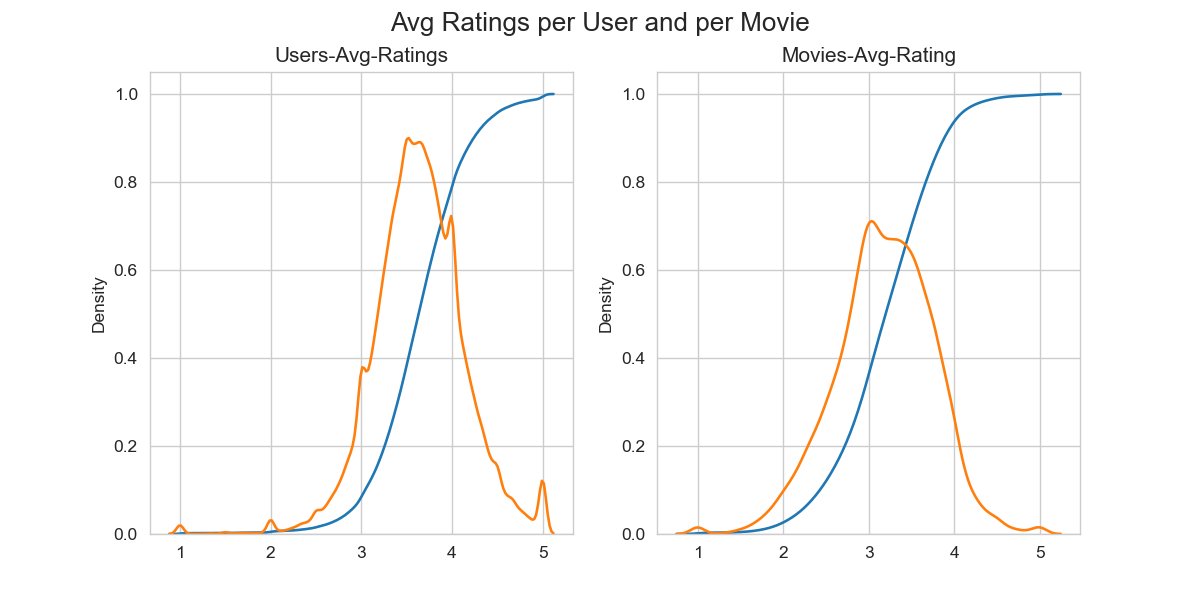

0:00:18.774809


In [36]:
start = datetime.now()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

<h3> Cold Start problem </h3>

In [37]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 322358

No of Users that didn't appear in train data: 157831(32.87 %) 
 


<h4> Cold Start problem with Movies</h4>

In [38]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 16376

No of Movies that didn't appear in train data: 1394(7.84 %) 
 


<h2>Computing Similarity matrices </h2>

<h4> Trying with all dimensions (17k dimensions per user) </h4>

In [12]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind))
    time_taken = list() #  time taken for finding similar users for an user..
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        

    if verbose: print('Creating Sparse matrix from the computed similarities')
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:01:49.864481  ]
computing done for 40 users [  time elapsed : 0:03:38.715412  ]
computing done for 60 users [  time elapsed : 0:05:25.136138  ]
computing done for 80 users [  time elapsed : 0:07:12.123558  ]
computing done for 100 users [  time elapsed : 0:08:55.833558  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


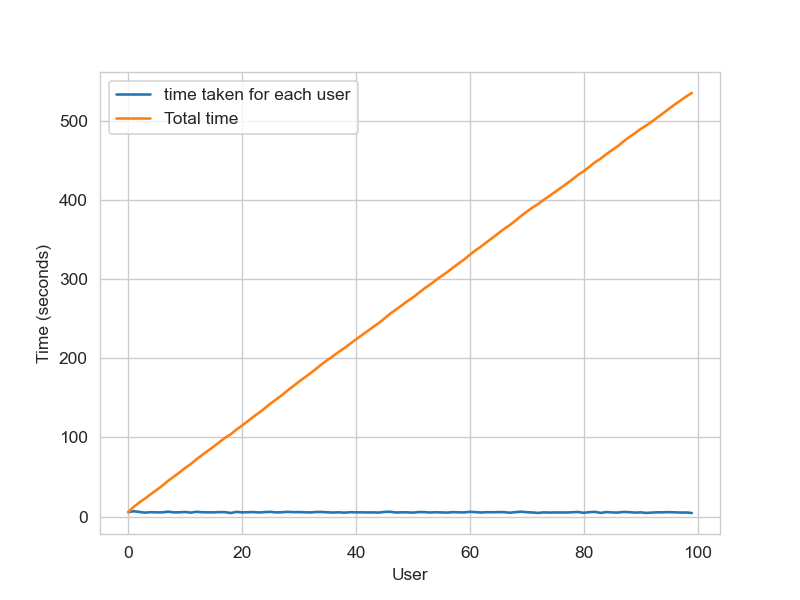

----------------------------------------------------------------------------------------------------
Time taken : 0:09:09.199321


In [13]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

<h3> Computing Movie-Movie Similarity matrix </h3>

In [14]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (17771, 17771)  dimensional matrix
0:00:46.868041


In [15]:
m_m_sim_sparse.shape

(17771, 17771)

In [16]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:01:26.122154


array([ 8013,  3755, 12049, 16528,  5927,  8279,  9071,  4424,  4549,
       13105,  3973, 15054, 10193,  6116, 15144,  3714, 16581,  3123,
       16417,  2788,  5370, 16455,  9584,  9376,  4706,  9802,  8003,
        6349, 16402, 15390,   590, 14059, 13267, 10250,  5465, 12567,
       16773,  9730,  6292,  8622,  1596, 17139,  8858,  5124,   389,
       16230, 17018,  4969,  1211,  9566, 16140,  4750, 15020,  2237,
         812,  2535,  2486, 11157,  1253,  8057,  6755,  1134,  2145,
       10597,  1720,  8988,  2187, 13931, 11981, 11730,  2818,  1942,
         598, 10788,   565,  1690, 17590, 10199,  8000,  4513,  9166,
       16309,  9558,  4376,  5865,  9688, 15360,  7845,  8218,  1510,
       12762,  3706,  9427,  6410, 11175, 11305, 13989,   376,  7481,
        2716], dtype=int64)

<h3> Finding most similar movies using similarity matrix </h3>

In [27]:
def manual_separation(bad_line):
    right_split = bad_line[:-2] + [",".join(bad_line[-2:])] # All the "bad lines" where all coming from the same last column that was containing ","
    return right_split

filename = "movie_titles.csv"
movie_titles = pd.read_csv(
        filename, 
        header=None,
        encoding="ISO-8859-1",
        names = ['Movie_Id', 'year_of_release', 'title'], 
        on_bad_lines=manual_separation,
        engine="python",
    )


In [28]:
movie_titles.head()

,Movie_Id,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


<p style='font-size:15px'><b>Similar Movies for 'Vampire Journals'</b></p>

In [29]:
mv_id = 67

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> 2004.0

It has 233 Ratings from users.

We have 16104 movies which are similarto this  and we will get only top most..


In [30]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] 

<IPython.core.display.Javascript object>


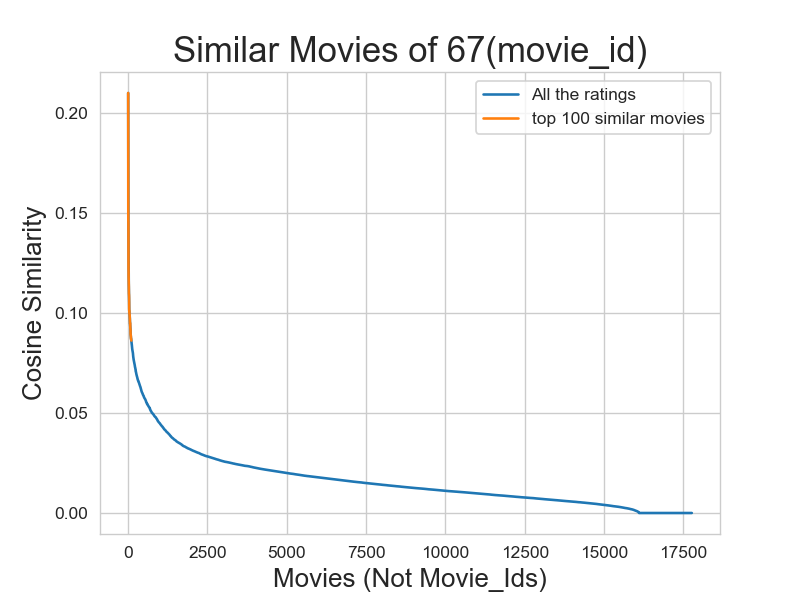

In [31]:
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

__Top 10 similar movies__

In [32]:
movie_titles.loc[sim_indices[:10]]

,Movie_Id,year_of_release,title
323,324,1994.0,Mother's Boys
4044,4045,2003.0,The Indiana Jones Trilogy: Bonus Material
1688,1689,2003.0,Concert for George
1900,1901,1978.0,Cheech & Chong's Up in Smoke
4667,4668,1993.0,Diary of Jack the Ripper
12053,12054,1988.0,Child's Play
16279,16280,1934.0,Triumph of the Will
13962,13963,1989.0,The Karate Kid Part III / The Next Karate Kid
13873,13874,2003.0,Little House on the Prairie: There's No Place ...
7573,7574,2002.0,Ronald Reagan: A Legacy Remembered


 <h1> Machine Learning Models </h1>

In [33]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):

    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h2>  Sampling Data </h2>

<h3> Build sample train data from the train data</h3>

In [36]:
start = datetime.now()
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (322358 16376)
Original Matrix : Ratings -- 58725000

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 104197
Saving it into disk for furthur usage..
Done..

0:00:54.762131


<h3> Build sample test data from the test data</h3>

In [38]:
start = datetime.now()

path = "sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:14.803139


<h2>Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)</h2>

In [39]:
sample_train_averages = dict()

<h3> Finding Global Average of all movie ratings</h3>

In [40]:
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5227885639701717}

<h3>Finding Average rating per User</h3>

In [58]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 500 :',sample_train_averages['movie'][500])


 AVerage rating of movie 500 : 3.8461538461538463


<h2> Featurizing data </h2>

In [62]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 104197


 No of ratings in Our Sampled test  matrix is : 7333



<h3> Featurizing data for regression problem </h3>

<h4> Featurizing train data </h4>

In [63]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [66]:
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()    
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
       
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:]
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(sample_train_averages['user'][user])
            row.append(sample_train_averages['movie'][movie])

            row.append(rating)
            count = count + 1

            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.001588


__Reading from the file to make a Train_dataframe__

In [68]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h4> Featurizing test data </h4>

In [69]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [70]:
sample_train_averages['global']

3.5227885639701717

In [72]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

            try:
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] 
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise

            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            row.append(rating)
            count = count + 1

            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


#### Reading from the file to make a test dataframe

In [73]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


<h3> Transforming data for Surprise models</h3>

In [82]:
from surprise import Reader, Dataset

<h4> Transforming train data </h4>

In [83]:
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata, It is of dataset format from surprise library
trainset = train_data.build_full_trainset() 

<h4> Transforming test data </h4>

In [84]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

<h2>  Applying Machine Learning models </h2>

In [85]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [86]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape


def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
   
    
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    
    # get the rmse and mape of train data
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    return train_results, test_results
    

In [88]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)


def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred


def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

def run_surprise(algo, trainset, testset, verbose=True): 
    start = datetime.now()
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)

    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h3> XGBoost with initial 13 features </h3>

In [90]:
import xgboost as xgb

Training the model..
[13:58:55] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Done. Time taken : 0:00:04.508807

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1016770831525975
MAPE :  33.379025364595144


<IPython.core.display.Javascript object>


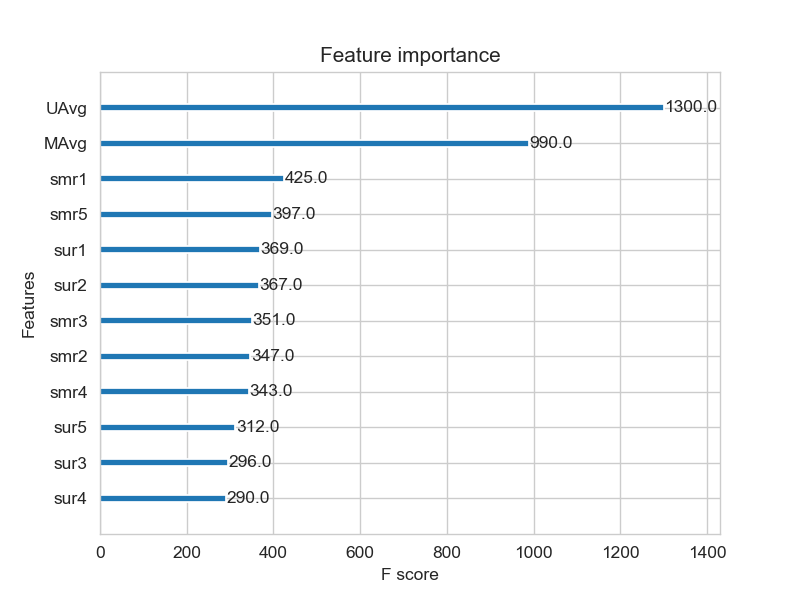

In [91]:
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

<h3> Suprise BaselineModel </h3>


In [92]:
from surprise import BaselineOnly 

__Predicted_rating : ( baseline prediction ) __

 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

In [93]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.791358 

Evaluating the model with train data..
time taken : 0:00:00.946991
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.228596
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:01.967232


<h3> XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [94]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


__Updating Test Data__

In [95]:
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


Training the model..
[14:02:37] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Done. Time taken : 0:00:07.835149

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1000463052939882
MAPE :  33.440093738533456


<IPython.core.display.Javascript object>


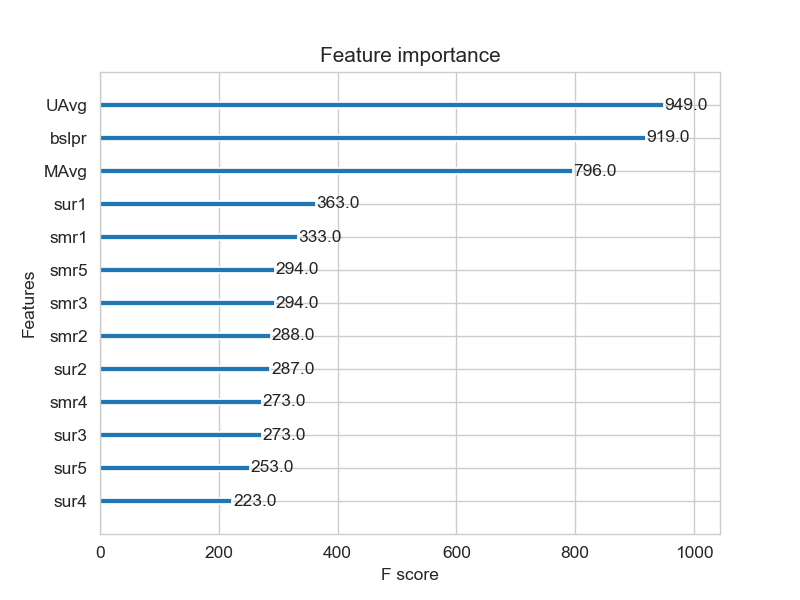

In [96]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


<h3>Surprise KNNBaseline predictor </h3>

In [97]:
from surprise import KNNBaseline

  <h4> Surprise KNNBaseline with user user similarities</h4>

In [98]:
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:36.732810 

Evaluating the model with train data..
time taken : 0:01:39.159954
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.046865
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:15.939629


<h4> Surprise KNNBaseline with movie movie similarities</h4>

In [99]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.386745 

Evaluating the model with train data..
time taken : 0:00:08.277873
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.046877
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.711495


<h3>  XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

#### Preparing Train data

In [100]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302


#### Preparing Test data 

In [101]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679


Training the model..
Done. Time taken : 0:00:09.071555

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0887576141058135
MAPE :  33.83328394123822


<IPython.core.display.Javascript object>


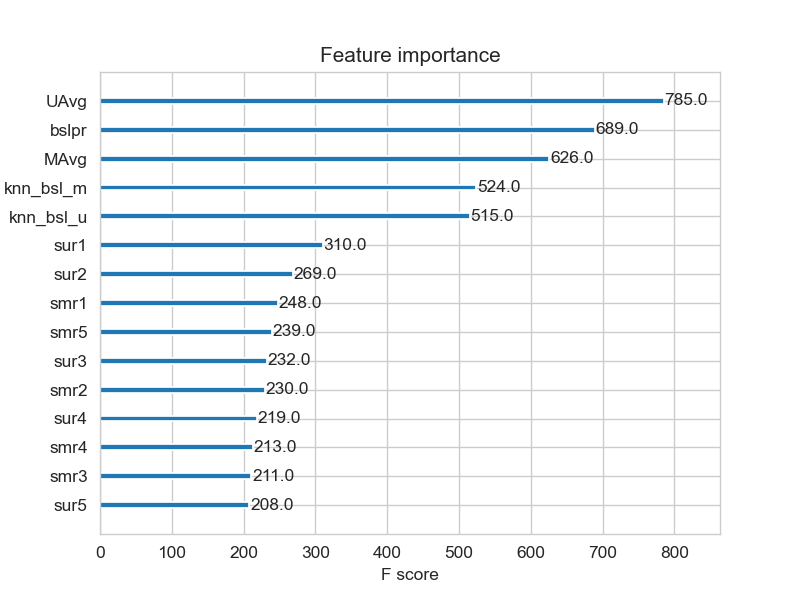

In [102]:
# prepare the train data
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3>  Matrix Factorization Techniques </h3>

In [103]:
from surprise import SVD

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [104]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.569675 

Evaluating the model with train data..
time taken : 0:00:01.524754
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660478

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.107664
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.203581


  <h4> SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [105]:
from surprise import SVDpp

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [106]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:02:12.375167 

Evaluating the model with train data..
time taken : 0:00:05.558893
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.054507
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:17.989577


<h3> XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [107]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


#### Preparing Test data 

In [108]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


Training the model..
Done. Time taken : 0:00:13.549746

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0858226171103014
MAPE :  33.98041189391535


<IPython.core.display.Javascript object>


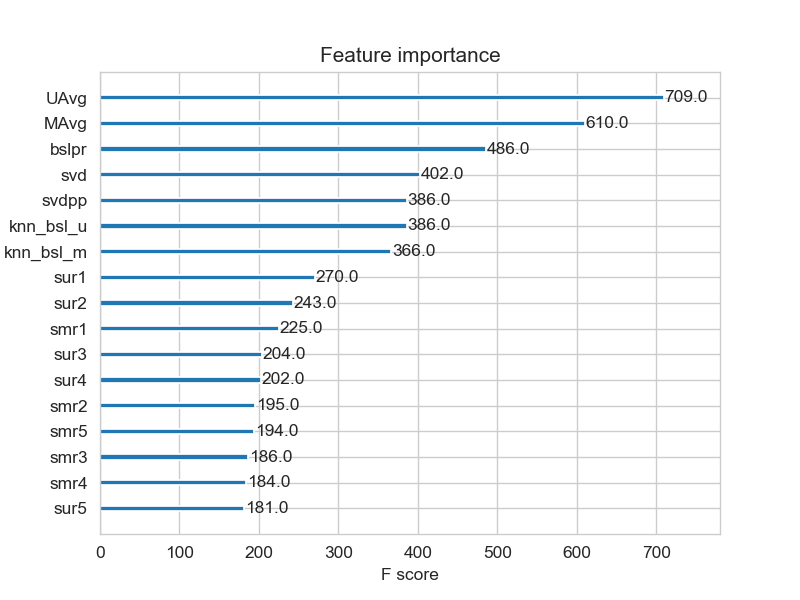

In [109]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

Training the model..
Done. Time taken : 0:00:06.973567

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0758207642755726
MAPE :  34.98203479380461


<IPython.core.display.Javascript object>


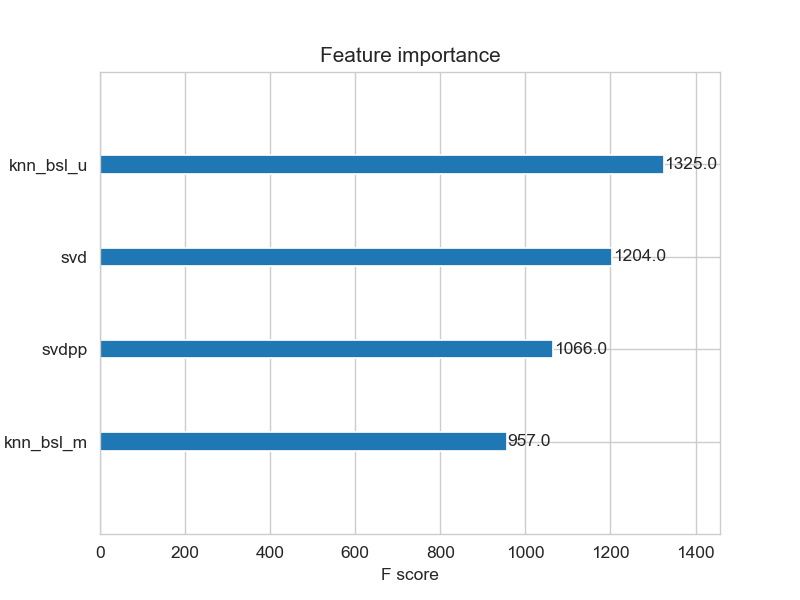

In [110]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

<h2> Comparision between all models </h2>

In [112]:
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u         1.0726493739667242
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_all_models    1.0758207642755726
xgb_final         1.0858226171103014
xgb_knn_bsl       1.0887576141058135
xgb_bsl           1.1000463052939882
first_algo        1.1016770831525975
Name: rmse, dtype: object